In [ ]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 5.2 MB/s 


In [ ]:
import os
import cv2
import copy
import pandas as pd
from PIL import Image
import numpy as np
import mahotas
from matplotlib import pyplot as plt
from glob import glob
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
import random
import torch
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.functional import Tensor
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.activation import ReLU
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import kurtosis, skew, entropy
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import skimage
from skimage import io, exposure, morphology, filters, color, segmentation, feature, measure, img_as_float, img_as_ubyte, transform
import seaborn as sns
import pickle
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.optim as optim
from tqdm import tqdm
from google.colab import drive
from pathlib import Path
from sklearn.utils import shuffle

/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [ ]:
!pip install -U scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.5 MB 5.1 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Directories
input_directory = '/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem Preprocessed'
train_directory = input_directory+'/train' 
val_directory = input_directory+'/val'

In [ ]:
#Training set organization
train_bcc= sorted(glob(os.path.join(train_directory, "bcc", "*.jpg")))
train_mel= sorted(glob(os.path.join(train_directory, "mel", "*.jpg")))
train_scc= sorted(glob(os.path.join(train_directory, "scc", "*.jpg")))
tags_bcc_train=[]
tags_mel_train=[]
tags_scc_train=[]
tags_train=[]
images_bcc=[]
images_mel=[]
images_scc=[]
labels_bcc=[]
labels_mel=[]
labels_scc=[]

In [ ]:
#Validation set organization
train_bcc_val= sorted(glob(os.path.join(val_directory, "bcc", "*.jpg")))
train_mel_val= sorted(glob(os.path.join(val_directory, "mel", "*.jpg")))
train_scc_val= sorted(glob(os.path.join(val_directory, "scc", "*.jpg")))
tags_bcc_val=[]
tags_mel_val=[]
tags_scc_val=[]
tags_val=[]
images_bcc_val=[]
images_mel_val=[]
images_scc_val=[]
labels_bcc_val=[]
labels_mel_val=[]
labels_scc_val=[]

In [ ]:
print(len(train_bcc))
print(len(train_mel))
print(len(train_scc))
print(len(train_bcc_val))
print(len(train_mel_val))
print(len(train_scc_val))

2713
2713
2632
498
678
94


In [ ]:
#Training set DataFrame construction
for i in range(len(train_mel)):
  tags_mel_train.append(train_mel[i][-12:])
  labels_mel.append(0)
for i in range(len(train_bcc)):
  tags_bcc_train.append(train_bcc[i][-12:])
  labels_bcc.append(1)
for i in range(len(train_scc)):
  tags_scc_train.append(train_scc[i][-12:])
  labels_scc.append(2)

In [ ]:
#Validation set DataFrame construction
for i in range(len(train_mel_val)):
  tags_mel_val.append(train_mel_val[i][-12:])
  labels_mel_val.append(0)
for i in range(len(train_bcc_val)):
  tags_bcc_val.append(train_bcc_val[i][-12:])
  labels_bcc_val.append(1)
for i in range(len(train_scc_val)):
  tags_scc_val.append(train_scc_val[i][-12:])
  labels_scc_val.append(2)

In [ ]:
tags_train= tags_bcc_train + tags_mel_train + tags_scc_train
X_train= labels_bcc+labels_mel+labels_scc

In [ ]:
tags_val= tags_bcc_val + tags_mel_val+tags_scc_val
X_test= labels_bcc_val +labels_mel_val+labels_scc_val

In [ ]:
training_set= pd.DataFrame.from_dict({'Image Tag':tags_train, 'Image Route': train_bcc+train_mel+train_scc, 'Label': X_train})
valid_set= pd.DataFrame.from_dict({'Image Tag':tags_val, 'Image Route': train_bcc_val+train_mel_val+train_scc_val, 'Label': X_test})

In [ ]:
X_train_data= training_set['Image Route'].to_numpy()
y_train_data= training_set['Label'].to_numpy()
X_test_data= valid_set['Image Route'].to_numpy()
y_test_data= valid_set['Label'].to_numpy()

In [ ]:
X_train,y_train = shuffle(X_train_data,y_train_data, random_state= 42)
X_test,y_test= shuffle(X_test_data, y_test_data, random_state=42)

In [ ]:
class LBP:
  def __init__(self, points, radius):
    self.points= points
    self.radius= radius
  def compute(self,image,e=1e-08):
    lbp_feature= feature.local_binary_pattern(image, self.points, self.radius, method="uniform")
    (lbp_histogram,_)= np.histogram(lbp_feature.ravel(), bins=np.arange(0, self.points + 3))

    #Normalization of the histogram
    lbp_histogram= lbp_histogram.astype("float")
    lbp_histogram /= (lbp_histogram.sum()+e)

    return lbp_histogram


In [ ]:
def LBP_feature_extractor(images_routes):
  lbp_histograms1=[]
  lbp_histograms2=[]
  lbp_histograms3=[]
  mean_histograms1=[]
  mean_histograms2=[]
  mean_histograms3=[]
  std_histograms1=[]
  std_histograms2=[]
  std_histograms3=[]
  kurtosis_histograms1=[]
  kurtosis_histograms2=[]
  kurtosis_histograms3=[]
  skew_histograms1=[]
  skew_histograms2=[]
  skew_histograms3=[]
  entropy_histograms1=[]
  entropy_histograms2=[]
  entropy_histograms3=[]
  lbp_object1= LBP(8,1)
  lbp_object2= LBP(16,2)
  lbp_object3= LBP(24,3)
  for i in images_routes:
    img= cv2.imread(i)
    img_bw= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    lbp_hist1=lbp_object1.compute(img_bw)
    lbp_hist2=lbp_object2.compute(img_bw)
    lbp_hist3=lbp_object3.compute(img_bw)
    mean_histograms1.append(np.mean(lbp_hist1))
    mean_histograms2.append(np.mean(lbp_hist2))
    mean_histograms3.append(np.mean(lbp_hist3))

    std_histograms1.append(np.std(lbp_hist1))
    std_histograms2.append(np.std(lbp_hist2))
    std_histograms3.append(np.std(lbp_hist3))

    kurtosis_histograms1.append(kurtosis(lbp_hist1))
    kurtosis_histograms2.append(kurtosis(lbp_hist2))
    kurtosis_histograms3.append(kurtosis(lbp_hist3))

    skew_histograms1.append(skew(lbp_hist1))
    skew_histograms2.append(skew(lbp_hist2))
    skew_histograms3.append(skew(lbp_hist3))

    entropy_histograms1.append(entropy(lbp_hist1))
    entropy_histograms2.append(entropy(lbp_hist2))
    entropy_histograms3.append(entropy(lbp_hist3))

    lbp_histograms1.append(lbp_hist1)
    lbp_histograms2.append(lbp_hist2)
    lbp_histograms3.append(lbp_hist3)

  LBP_features1= pd.DataFrame(data= lbp_histograms1)
  LBP_features2= pd.DataFrame(data= lbp_histograms2)
  LBP_features3= pd.DataFrame(data= lbp_histograms3)

  LBP_Statistics1= {'mean': mean_histograms1, 'std':std_histograms1, 'kurtosis': kurtosis_histograms1, 'skew': skew_histograms1, 'entropy': entropy_histograms1}
  LBP_Statistics2= {'mean': mean_histograms2, 'std':std_histograms2, 'kurtosis': kurtosis_histograms2, 'skew': skew_histograms2, 'entropy': entropy_histograms2}
  LBP_Statistics3= {'mean': mean_histograms3, 'std':std_histograms3, 'kurtosis': kurtosis_histograms3, 'skew': skew_histograms3, 'entropy': entropy_histograms3}

  LBP_statistics1_result= pd.DataFrame.from_dict(LBP_Statistics1)
  LBP_statistics2_result= pd.DataFrame.from_dict(LBP_Statistics2)
  LBP_statistics3_result= pd.DataFrame.from_dict(LBP_Statistics3)


  return LBP_features1, LBP_features2, LBP_features3, LBP_statistics1_result, LBP_statistics2_result, LBP_statistics3_result

In [ ]:
LBP_features1_train, LBP_features2_train, LBP_features3_train, LBP_statistics1_result_train, LBP_statistics2_result_train, LBP_statistics3_result_train= LBP_feature_extractor(X_train)
LBP_features1_test, LBP_features2_test, LBP_features3_test, LBP_statistics1_result_test, LBP_statistics2_result_test, LBP_statistics3_result_test= LBP_feature_extractor(X_test)

In [ ]:
LBP_features1_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/LBP_features1_train_291022.csv',index=False)
LBP_features2_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/LBP_features2_train_291022.csv',index=False)
LBP_features3_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/LBP_LBP_features3_train_291022.csv',index=False)
LBP_statistics1_result_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/LBP_statistics1_result_train_291022.csv',index=False)
LBP_statistics2_result_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/LBP_statistics2_result_train_291022.csv',index=False)
LBP_statistics3_result_train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/LBP_statistics3_result_train_291022.csv',index=False)

LBP_features1_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/LBP_features1_test_291022.csv',index=False)
LBP_features2_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/LBP_features2_test_291022.csv',index=False)
LBP_features3_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/LBP_features3_test_291022.csv',index=False)
LBP_statistics1_result_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/LBP_statistics1_result_test_291022.csv',index=False)
LBP_statistics2_result_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/LBP_statistics2_result_test_291022.csv',index=False)
LBP_statistics3_result_test.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/LBP_statistics3_result_test_29022.csv',index=False)

In [ ]:
LBP_histogram_features_train= pd.concat([LBP_features1_train, LBP_features2_train, LBP_features3_train], axis=1)
LBP_histogram_features_test= pd.concat([LBP_features1_test, LBP_features2_test, LBP_features3_test], axis=1)

In [ ]:
LBP_statistics_features_train= pd.concat([LBP_statistics1_result_train,LBP_statistics2_result_train, LBP_statistics3_result_train], axis=1)
LBP_statistics_features_test= pd.concat([LBP_statistics1_result_test,LBP_statistics2_result_test, LBP_statistics3_result_test], axis=1)

In [ ]:
X_train_features= LBP_histogram_features_train
X_test_features= LBP_histogram_features_test
scaler= StandardScaler().fit(X_train_features)
X_train_scaled= scaler.transform(X_train_features)
X_test_scaled= scaler.transform(X_test_features)

First model: SVM

In [ ]:
model1= svm.SVC()
model1.fit(X_train_scaled,y_train)
y_pred1= model1.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred1))
print(balanced_accuracy_score(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.82      0.67      0.74       678
           1       0.66      0.58      0.62       498
           2       0.16      0.47      0.24        94

    accuracy                           0.62      1270
   macro avg       0.55      0.57      0.53      1270
weighted avg       0.71      0.62      0.65      1270

0.5723188996493096


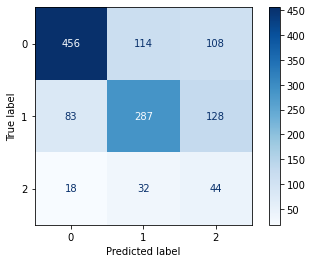

In [ ]:
cm= confusion_matrix(y_test,y_pred1,labels= model1.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Second Model: Logistic Regression

In [ ]:
model2= LogisticRegression(max_iter=2000)
model2.fit(X_train_scaled,y_train)
y_pred2= model2.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred2))
print(balanced_accuracy_score(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       678
           1       0.68      0.60      0.64       498
           2       0.16      0.44      0.23        94

    accuracy                           0.64      1270
   macro avg       0.56      0.58      0.54      1270
weighted avg       0.72      0.64      0.67      1270

0.5792316318559873


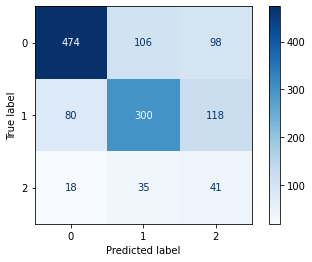

In [ ]:
cm= confusion_matrix(y_test,y_pred2,labels= model2.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Third model: Gradient Boosting

In [ ]:
model3= GradientBoostingClassifier(random_state=42)
model3.fit(X_train_scaled,y_train)
y_pred3= model3.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred3))
print(balanced_accuracy_score(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.78      0.67      0.72       678
           1       0.63      0.56      0.59       498
           2       0.16      0.41      0.23        94

    accuracy                           0.61      1270
   macro avg       0.52      0.55      0.51      1270
weighted avg       0.68      0.61      0.63      1270

0.5475810226407418


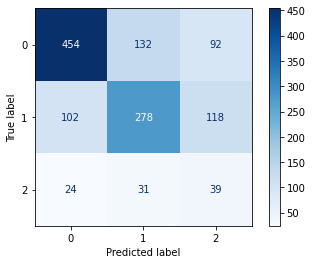

In [ ]:
cm= confusion_matrix(y_test,y_pred3,labels= model3.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Fourth Model: Random Forest Classifier

In [ ]:
model4= RandomForestClassifier(random_state=42)
model4.fit(X_train_scaled,y_train)
y_pred4= model4.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred4))
print(balanced_accuracy_score(y_test,y_pred4))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74       678
           1       0.67      0.61      0.64       498
           2       0.21      0.45      0.28        94

    accuracy                           0.65      1270
   macro avg       0.55      0.59      0.56      1270
weighted avg       0.70      0.65      0.67      1270

0.589074303868332


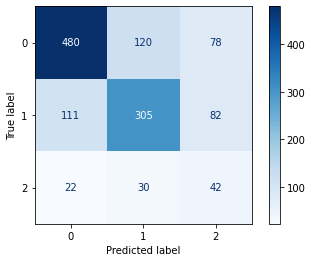

In [ ]:
cm= confusion_matrix(y_test,y_pred4,labels= model4.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Fifth model: AdaBoost classifier

In [ ]:
model5= AdaBoostClassifier(random_state=42)
model5.fit(X_train_scaled,y_train)
y_pred5= model5.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred5))
print(balanced_accuracy_score(y_test,y_pred5))

              precision    recall  f1-score   support

           0       0.77      0.63      0.69       678
           1       0.61      0.52      0.56       498
           2       0.13      0.39      0.19        94

    accuracy                           0.57      1270
   macro avg       0.50      0.51      0.48      1270
weighted avg       0.66      0.57      0.60      1270

0.5143192490037978


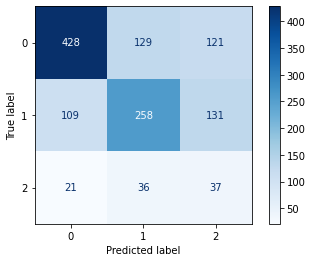

In [ ]:
cm= confusion_matrix(y_test,y_pred5,labels= model5.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model5.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Sixth Model: Decision Trees Classifier

In [ ]:
model6= DecisionTreeClassifier(random_state=42)
model6.fit(X_train_scaled,y_train)
y_pred6= model6.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred6))
print(balanced_accuracy_score(y_test,y_pred6))

              precision    recall  f1-score   support

           0       0.71      0.59      0.64       678
           1       0.54      0.46      0.50       498
           2       0.15      0.44      0.22        94

    accuracy                           0.53      1270
   macro avg       0.46      0.50      0.45      1270
weighted avg       0.60      0.53      0.55      1270

0.49501275043058063


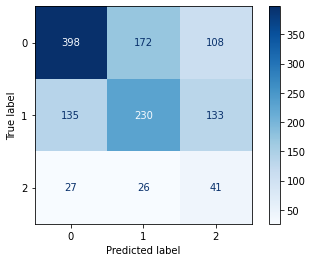

In [ ]:
cm= confusion_matrix(y_test,y_pred6,labels= model6.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model6.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Seventh model: XGBoost Classifier

In [ ]:
model7= XGBClassifier(random_state=42)
model7.fit(X_train_scaled,y_train)
y_pred7= model7.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred7))
print(balanced_accuracy_score(y_test,y_pred7))

              precision    recall  f1-score   support

           0       0.77      0.66      0.71       678
           1       0.62      0.55      0.58       498
           2       0.15      0.39      0.22        94

    accuracy                           0.60      1270
   macro avg       0.51      0.54      0.50      1270
weighted avg       0.67      0.60      0.62      1270

0.5350392973387305


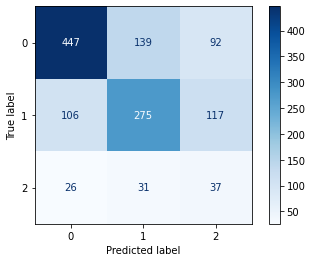

In [ ]:
cm= confusion_matrix(y_test,y_pred7,labels= model7.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model7.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eigth model: Naive Bayes Classifier

In [ ]:
model8= GaussianNB()
model8.fit(X_train_scaled,y_train)
y_pred8= model8.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred8))
print(balanced_accuracy_score(y_test,y_pred8))

              precision    recall  f1-score   support

           0       0.77      0.29      0.42       678
           1       0.52      0.50      0.51       498
           2       0.10      0.60      0.18        94

    accuracy                           0.40      1270
   macro avg       0.47      0.46      0.37      1270
weighted avg       0.62      0.40      0.44      1270

0.4630850017782799


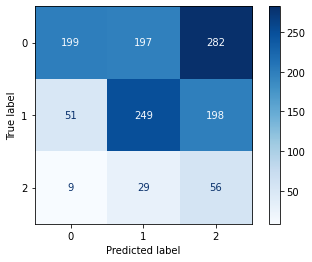

In [ ]:
cm= confusion_matrix(y_test,y_pred8,labels= model8.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model8.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Ninth Model: KNeighbors Classifier

In [ ]:
model9= KNeighborsClassifier()
model9.fit(X_train_scaled,y_train)
y_pred9= model9.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred9))
print(balanced_accuracy_score(y_test,y_pred9))

              precision    recall  f1-score   support

           0       0.76      0.66      0.71       678
           1       0.62      0.53      0.57       498
           2       0.18      0.48      0.26        94

    accuracy                           0.60      1270
   macro avg       0.52      0.56      0.51      1270
weighted avg       0.66      0.60      0.62      1270

0.5556899032772022


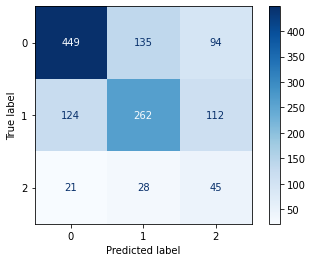

In [ ]:
cm= confusion_matrix(y_test,y_pred9,labels= model9.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model9.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Tenth Model: Bagging Classifier

In [ ]:
model10= BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),n_estimators=10,random_state=42)
model10.fit(X_train_scaled,y_train)
y_pred10= model10.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred10))
print(balanced_accuracy_score(y_test,y_pred10))

              precision    recall  f1-score   support

           0       0.79      0.71      0.75       678
           1       0.68      0.59      0.63       498
           2       0.20      0.49      0.29        94

    accuracy                           0.65      1270
   macro avg       0.56      0.60      0.56      1270
weighted avg       0.70      0.65      0.67      1270

0.5968792007293594


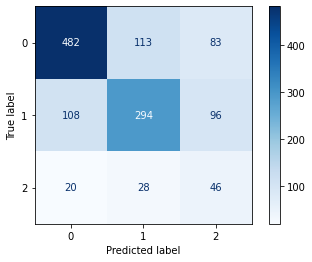

In [ ]:
cm= confusion_matrix(y_test,y_pred10,labels= model10.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model10.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eleventh Model: Stacking Classifier

In [ ]:
def get_stack_model():
  level0 = list()
  level0.append(('lr', LogisticRegression(max_iter=2000,random_state=42)))
  level0.append(('knn', KNeighborsClassifier()))
  level0.append(('cart', DecisionTreeClassifier(random_state=42)))
  level0.append(('svm', svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr', random_state=42)))
  level0.append(('bayes', GaussianNB()))
  level0.append(('gboosting', GradientBoostingClassifier(random_state=42)))
  level0.append(('rforest', RandomForestClassifier(random_state=42)))
  level0.append(('adaboost', AdaBoostClassifier(random_state=42)))
  level1 = LogisticRegression(max_iter=2000,random_state=42)
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model

In [ ]:
model11=get_stack_model()
model11.fit(X_train_scaled,y_train)
y_pred11= model11.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred11))
print(balanced_accuracy_score(y_test,y_pred11))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76       678
           1       0.68      0.67      0.68       498
           2       0.22      0.40      0.28        94

    accuracy                           0.68      1270
   macro avg       0.57      0.60      0.57      1270
weighted avg       0.72      0.68      0.69      1270

0.5989033646668517


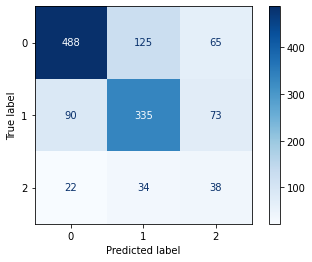

In [ ]:
cm= confusion_matrix(y_test,y_pred11,labels= model11.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model11.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [ ]:
X_train_features= LBP_statistics_features_train
X_test_features= LBP_statistics_features_test
scaler= StandardScaler().fit(X_train_features)
X_train_scaled= scaler.transform(X_train_features)
X_test_scaled= scaler.transform(X_test_features)

First model: SVM

In [ ]:
model1= svm.SVC()
model1.fit(X_train_scaled,y_train)
y_pred1= model1.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred1))
print(balanced_accuracy_score(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.72      0.58      0.64       678
           1       0.55      0.48      0.51       498
           2       0.14      0.44      0.21        94

    accuracy                           0.53      1270
   macro avg       0.47      0.50      0.45      1270
weighted avg       0.61      0.53      0.56      1270

0.4974176502659102


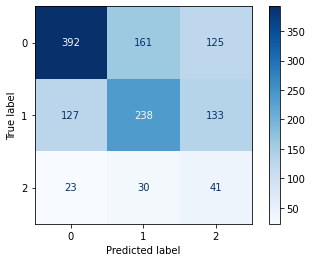

In [ ]:
cm= confusion_matrix(y_test,y_pred1,labels= model1.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Second Model: Logistic Regression

In [ ]:
model2= LogisticRegression(max_iter=2000)
model2.fit(X_train_scaled,y_train)
y_pred2= model2.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred2))
print(balanced_accuracy_score(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.70      0.57      0.63       678
           1       0.54      0.43      0.48       498
           2       0.12      0.41      0.19        94

    accuracy                           0.50      1270
   macro avg       0.45      0.47      0.43      1270
weighted avg       0.59      0.50      0.54      1270

0.47229462631798763


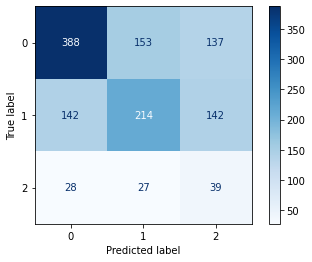

In [ ]:
cm= confusion_matrix(y_test,y_pred2,labels= model2.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Third model: Gradient Boosting

In [ ]:
model3= GradientBoostingClassifier(random_state=42)
model3.fit(X_train_scaled,y_train)
y_pred3= model3.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred3))
print(balanced_accuracy_score(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.75      0.63      0.69       678
           1       0.59      0.53      0.56       498
           2       0.16      0.41      0.23        94

    accuracy                           0.58      1270
   macro avg       0.50      0.53      0.49      1270
weighted avg       0.64      0.58      0.60      1270

0.5270801400543491


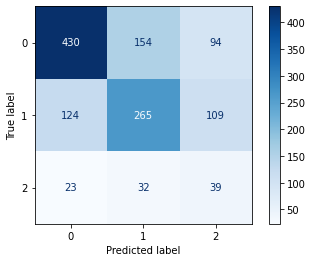

In [ ]:
cm= confusion_matrix(y_test,y_pred3,labels= model3.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Fourth Model: Random Forest Classifier

In [ ]:
model4= RandomForestClassifier(random_state=42)
model4.fit(X_train_scaled,y_train)
y_pred4= model4.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred4))
print(balanced_accuracy_score(y_test,y_pred4))

              precision    recall  f1-score   support

           0       0.75      0.67      0.70       678
           1       0.62      0.51      0.56       498
           2       0.18      0.48      0.26        94

    accuracy                           0.59      1270
   macro avg       0.52      0.55      0.51      1270
weighted avg       0.65      0.59      0.62      1270

0.5536404073584239


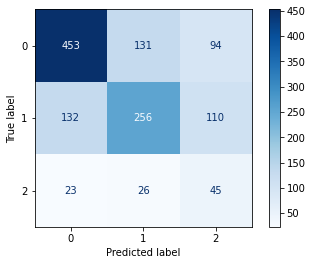

In [ ]:
cm= confusion_matrix(y_test,y_pred4,labels= model4.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Fifth model: AdaBoost classifier

In [ ]:
model5= AdaBoostClassifier(random_state=42)
model5.fit(X_train_scaled,y_train)
y_pred5= model5.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred5))
print(balanced_accuracy_score(y_test,y_pred5))

              precision    recall  f1-score   support

           0       0.71      0.53      0.60       678
           1       0.53      0.50      0.51       498
           2       0.11      0.35      0.17        94

    accuracy                           0.50      1270
   macro avg       0.45      0.46      0.43      1270
weighted avg       0.59      0.50      0.54      1270

0.45920416745120196


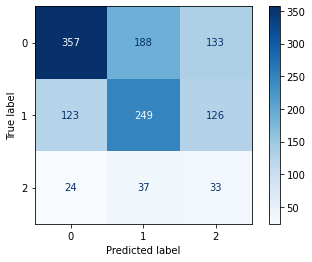

In [ ]:
cm= confusion_matrix(y_test,y_pred5,labels= model5.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model5.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Sixth Model: Decision Trees Classifier

In [ ]:
model6= DecisionTreeClassifier(random_state=42)
model6.fit(X_train_scaled,y_train)
y_pred6= model6.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred6))
print(balanced_accuracy_score(y_test,y_pred6))

              precision    recall  f1-score   support

           0       0.69      0.55      0.61       678
           1       0.50      0.47      0.48       498
           2       0.13      0.36      0.19        94

    accuracy                           0.50      1270
   macro avg       0.44      0.46      0.43      1270
weighted avg       0.58      0.50      0.53      1270

0.4595930952832859


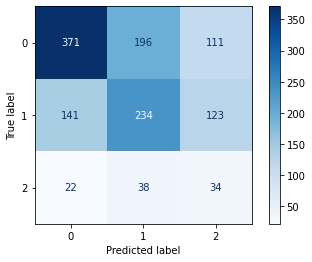

In [ ]:
cm= confusion_matrix(y_test,y_pred6,labels= model6.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model6.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Seventh model: XGBoost Classifier

In [ ]:
model7= XGBClassifier(random_state=42)
model7.fit(X_train_scaled,y_train)
y_pred7= model7.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred7))
print(balanced_accuracy_score(y_test,y_pred7))

              precision    recall  f1-score   support

           0       0.75      0.59      0.66       678
           1       0.57      0.58      0.57       498
           2       0.17      0.39      0.23        94

    accuracy                           0.57      1270
   macro avg       0.49      0.52      0.49      1270
weighted avg       0.64      0.57      0.60      1270

0.5227778622177154


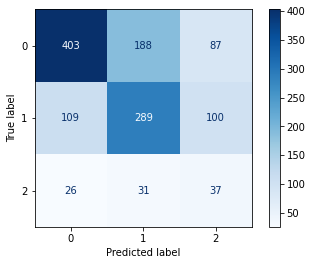

In [ ]:
cm= confusion_matrix(y_test,y_pred7,labels= model7.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model7.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eigth model: Naive Bayes Classifier

In [ ]:
model8= GaussianNB()
model8.fit(X_train_scaled,y_train)
y_pred8= model8.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred8))
print(balanced_accuracy_score(y_test,y_pred8))

              precision    recall  f1-score   support

           0       0.55      0.07      0.12       678
           1       0.43      0.41      0.42       498
           2       0.08      0.57      0.13        94

    accuracy                           0.24      1270
   macro avg       0.35      0.35      0.22      1270
weighted avg       0.47      0.24      0.24      1270

0.34931239424527966


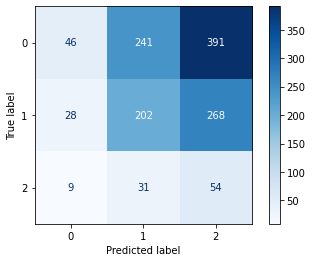

In [ ]:
cm= confusion_matrix(y_test,y_pred8,labels= model8.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model8.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Ninth Model: KNeighbors Classifier

In [ ]:
model9= KNeighborsClassifier()
model9.fit(X_train_scaled,y_train)
y_pred9= model9.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred9))
print(balanced_accuracy_score(y_test,y_pred9))

              precision    recall  f1-score   support

           0       0.73      0.63      0.68       678
           1       0.57      0.48      0.52       498
           2       0.13      0.36      0.19        94

    accuracy                           0.55      1270
   macro avg       0.48      0.49      0.46      1270
weighted avg       0.62      0.55      0.58      1270

0.49230210240321104


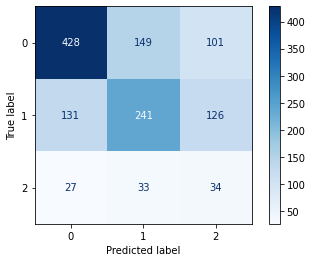

In [ ]:
cm= confusion_matrix(y_test,y_pred9,labels= model9.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model9.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Tenth Model: Bagging Classifier

In [ ]:
model10= BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),n_estimators=10,random_state=42)
model10.fit(X_train_scaled,y_train)
y_pred10= model10.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred10))
print(balanced_accuracy_score(y_test,y_pred10))

              precision    recall  f1-score   support

           0       0.76      0.66      0.71       678
           1       0.62      0.54      0.58       498
           2       0.17      0.44      0.24        94

    accuracy                           0.60      1270
   macro avg       0.52      0.55      0.51      1270
weighted avg       0.66      0.60      0.62      1270

0.5455215703711097


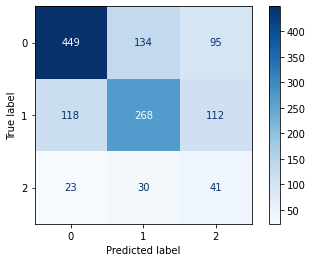

In [ ]:
cm= confusion_matrix(y_test,y_pred10,labels= model10.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model10.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eleventh Model: Stacking Classifier

In [ ]:
def get_stack_model():
  level0 = list()
  level0.append(('lr', LogisticRegression(max_iter=2000,random_state=42)))
  level0.append(('knn', KNeighborsClassifier()))
  level0.append(('cart', DecisionTreeClassifier(random_state=42)))
  level0.append(('svm', svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr', random_state=42)))
  level0.append(('bayes', GaussianNB()))
  level0.append(('gboosting', GradientBoostingClassifier(random_state=42)))
  level0.append(('rforest', RandomForestClassifier(random_state=42)))
  level0.append(('adaboost', AdaBoostClassifier(random_state=42)))
  level1 = LogisticRegression(max_iter=2000,random_state=42)
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model

In [ ]:
model11=get_stack_model()
model11.fit(X_train_scaled,y_train)
y_pred11= model11.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred11))
print(balanced_accuracy_score(y_test,y_pred11))

              precision    recall  f1-score   support

           0       0.76      0.68      0.72       678
           1       0.63      0.54      0.59       498
           2       0.19      0.46      0.27        94

    accuracy                           0.61      1270
   macro avg       0.53      0.56      0.52      1270
weighted avg       0.67      0.61      0.63      1270

0.5619964323496206


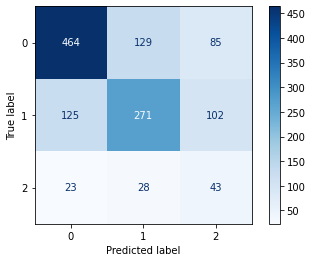

In [ ]:
cm= confusion_matrix(y_test,y_pred11,labels= model11.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model11.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()